# Section 4.3 The $\alpha-\beta$ random kernel model

This page contains simulations in Section 4.3.

## Contents

    - Eigenspectrum of $\Phi$
    - Limiting spectra of $\alpha-\beta$ kernel


## Eigenspectrum of $\Phi$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
pi = np.pi

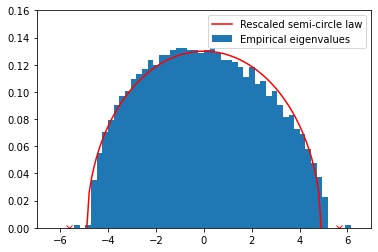

In [4]:
coeff = 2
p = 400*coeff
n = 1200*coeff
c = p/n

np.random.seed(928)
W = np.random.randn(p,n) # population covariance = identity

Phi = np.sqrt(p)*( (W.T@W/p)**2 - 1/p)
Phi = Phi - np.diag(np.diag(Phi))
eigs_Phi = np.linalg.eigh(Phi)[0]

omega = np.sqrt(2)
Omega = np.sqrt(2)

spike_location = Omega/c+omega**2/Omega
edges = np.linspace(-2*omega/np.sqrt(c), 2*omega/np.sqrt(c), 100)
mu = np.sqrt( 4*omega**2/c - edges**2 )*c/2/pi/omega**2

edges_Phi = np.linspace(np.min(eigs_Phi)-.1,np.max(eigs_Phi)+.1, 50)
plt.hist(eigs_Phi,bins=edges_Phi,weights=1/n/(edges_Phi[1]-edges_Phi[0])*np.ones(len(eigs_Phi)),label='Empirical eigenvalues')
plt.plot(edges,mu, 'r',label='Rescaled semi-circle law')
plt.plot([-spike_location, spike_location],[0,0],'rx')
plt.gca().set_xlim(-7,7)
plt.gca().set_ylim(0,.16)
_ = plt.legend()

## Limiting spectra of $\alpha-\beta$ kernel

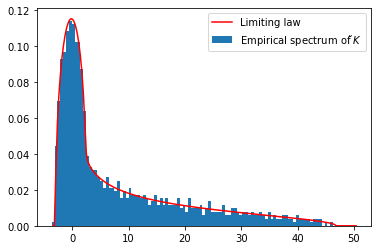

In [7]:
coeff = 1
p = 512*coeff
n = 1024*coeff
c = p/n

cs = [1/2, 1/2]
n_cs = n*cs
k = len(cs)  # number of classes

alpha = 8
beta = 1
f   = lambda t : beta*(t+alpha/2/beta/np.sqrt(p))**2
f_d = lambda t : 2*beta*(t+alpha/2/beta/np.sqrt(p))

testcase_option = 'iid'

if testcase_option == 'iid':
    means = lambda i : np.zeros(p)
    covs  = lambda i : np.eye(p)
    
if testcase_option == 'means':
    means = lambda i : np.concatenate([np.zeros(i-1),[1],np.zeros(p-i)])*5
    covs  = lambda i : np.eye(p)

if testcase_option == 'var':
    means = lambda i : np.zeros(p)
    covs  = lambda i : np.eye(p)*(1+(i-1)/np.sqrt(p)*10)

if testcase_option == 'orth':
    means = lambda i : np.zeros(p)
    covs  = lambda i : np.linalg.toeplitz([(6*(i-1)/10)**j for j in range(p)])

if testcase_option == 'mixed':
    means = lambda i : (-1)**i*np.concatenate([[1],np.zeros(p-1)])*2
    covs  = lambda i : np.eye(p)*(1+(i-1)/np.sqrt(p)*5)

covs_mean = cs[0]*covs(1) + cs[1]*covs(2)
eigs_covs_mean = np.linalg.eigh(covs_mean)[0]
tau = np.trace(covs_mean)/p

np.random.seed(928)
W=np.zeros( (p,n) )
for i in range(k):
    W[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=scipy.linalg.sqrtm(covs(i))@np.random.randn(p,int(cs[i]*n))

X=np.zeros((p,n))
for i in range(k):
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=W[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]+means(i).reshape(p,1)

P = np.eye(n) - np.ones((n,n))/n
X_center = X@P
XX = X_center.T@X_center

K = f(XX/p)
K = K - np.diag(np.diag(K))

PKP = P@K@P
rescale_PKP = np.sqrt(p)*(PKP + (f(0)+tau*f_d(0))*P)
eigs_rescale_PKP = np.linalg.eigh(rescale_PKP)[0]

omega = np.sqrt(2)*np.trace(covs_mean@covs_mean)/p

if np.min(eigs_rescale_PKP)<0:
    edges = np.linspace(np.min(eigs_rescale_PKP)*1.1, np.max(eigs_rescale_PKP)*1.1, 200)
else:
    edges = np.linspace(np.min(eigs_rescale_PKP)*0.9, np.max(eigs_rescale_PKP)*1.1, 200)

y = 1e-5
zs = edges+y*1j
mu = []

m=0
for z in zs:
    m_tmp=1
    while np.abs(m-m_tmp)>1e-6:
        m_tmp=m
        m = 1/( -z + alpha*np.mean(eigs_covs_mean/(1+alpha*m*eigs_covs_mean/c))-beta**2*omega**2*m/c)

    mu.append(np.imag(m)/pi)

edges_K = np.linspace(np.min(eigs_rescale_PKP)-.5,np.max(eigs_rescale_PKP)+.5,100)
plt.hist(eigs_rescale_PKP,bins=edges_K,weights=1/n/(edges_K[1]-edges_K[0])*np.ones(len(eigs_rescale_PKP)),label=r'Empirical spectrum of $\check K$')
plt.plot(edges,mu,'r',label=r'Limiting law')
_ = plt.legend()